# Building data-set

#### Get raw data from API

In [3]:
import requests
import csv
import os
import time

import pandas as pd

In [5]:
tickers_df = pd.read_csv('in/TICKERS.csv')

counter = 0

for index, row in tickers_df.iterrows():

    ticker = (f'{row["ticker"]}.SAO')
    path = (f'data/{ticker}.csv')

    key = 'XLSA5LZF5KUUXJX3'

    if not os.path.exists(path):
        
        if counter == 5:
            print('waiting...')
            time.sleep(70)
            counter = 0
        
        url = (f'https://www.alphavantage.co/query?apikey={key}&function=TIME_SERIES_DAILY_ADJUSTED&symbol={ticker}&datatype=csv&outputsize=full')

        response = requests.get(url)
        counter += 1

        if response.status_code == 200:
            content = response.content.decode()
            
            reader = csv.reader(content.splitlines(), delimiter=',')
            
            dataset = list(reader)
            
            with open(path, mode='w', newline='') as file:
                writer = csv.writer(file)
                writer.writerows(dataset)
                
            print(f"New .csv downloaded for {ticker}: {response.status_code}")
        else:
            print(f"Request failed for {ticker}: {response.status_code}")

New .csv downloaded for QUAL3.SAO: 200
New .csv downloaded for EGIE3.SAO: 200
New .csv downloaded for EGIE4.SAO: 200
New .csv downloaded for BRML3.SAO: 200
New .csv downloaded for MULT3.SAO: 200
waiting...
New .csv downloaded for GOLL3.SAO: 200
New .csv downloaded for RADL4.SAO: 200
New .csv downloaded for BRAP4.SAO: 200
New .csv downloaded for PCAR3.SAO: 200
New .csv downloaded for RAIL4.SAO: 200
waiting...


KeyboardInterrupt: 

#### Assemble data-set

In [20]:
with open("out/output.csv", mode='w', newline='') as file:
    
    writer = csv.writer(file)
    
    # write header
    writer.writerow(['ticker', 'av_close', 
                     'av_volume', 'av_dividend_amount',
                     'highest', 'lowest',
                     'difference'
                     ])
    
    tickers_df = pd.read_csv('in/TICKERS.csv')
    
    for index, row in tickers_df.iterrows():
        
        path = (f'data/{row["ticker"]}.SAO.csv')
        
        if os.path.exists(path):
            df = pd.read_csv(path)
            
            writer.writerow([
                                row['ticker'], 
                                df['close'].mean(), 
                                df['volume'].mean(), 
                                df['dividend_amount'].mean(),
                                df['close'].max(),
                                df['close'].min(),
                                df['close'].max() - df['close'].min(),
                            ]) 


#### Checking feature correlation

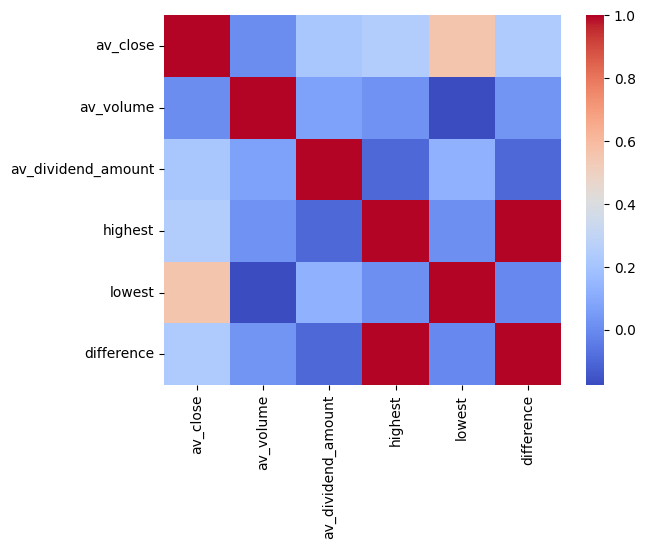

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('out/output.csv')
del df['ticker']

sns.heatmap(df.corr(), cmap='coolwarm')
plt.show()

# Building cluster model

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


In [23]:
df = pd.read_csv('out/output.csv')

# df = df[~(df["ticker"] == "BBDC3")]
# df = df[~(df["ticker"] == "NATU3")]

# X = df[['av_close', 'av_volume', 'av_dividend_amount', 'ATR', 'OBV']]
X = df[['av_close', 'av_volume', 'av_dividend_amount', 'highest', 'lowest']]

#### Evaluating best k

/home/carled7/Repositories/clustering-stocks/clustering-stocks-env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/carled7/Repositories/clustering-stocks/clustering-stocks-env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/carled7/Repositories/clustering-stocks/clustering-stocks-env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/carled7/Repositories/clustering-stocks/clustering-stocks-env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: Futur

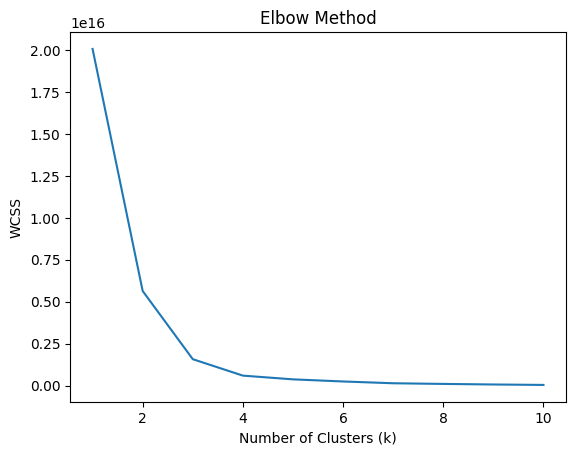

In [24]:
import matplotlib.pyplot as plt

wcss = []
for k in range(1, 11):  # Test different values of k
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # Inertia represents WCSS

plt.plot(range(1, 11), wcss)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

/home/carled7/Repositories/clustering-stocks/clustering-stocks-env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/carled7/Repositories/clustering-stocks/clustering-stocks-env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/carled7/Repositories/clustering-stocks/clustering-stocks-env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/carled7/Repositories/clustering-stocks/clustering-stocks-env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: Futur

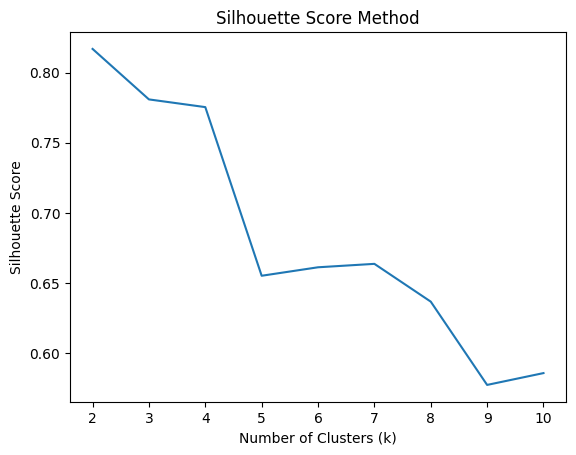

In [25]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 11):  # Test different values of k
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

plt.plot(range(2, 11), silhouette_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

#### Training and vizualizing results

In [26]:
kmeans = KMeans(n_clusters=2)  
kmeans.fit(X)

labels = kmeans.labels_

/home/carled7/Repositories/clustering-stocks/clustering-stocks-env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


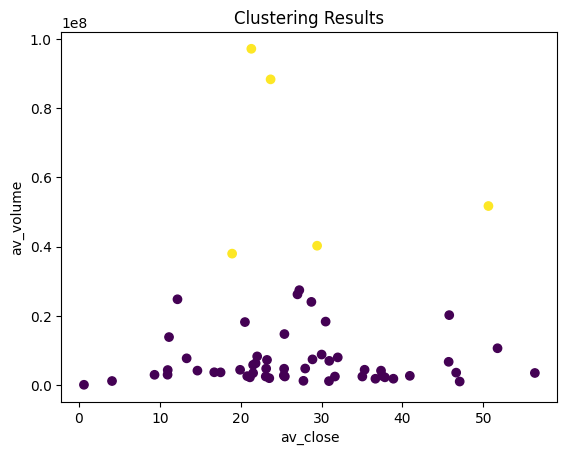

In [27]:
# Example visualization using matplotlib

plt.scatter(X['av_close'], X['av_volume'], c=labels)
plt.xlabel('av_close',)
plt.ylabel('av_volume')
plt.title('Clustering Results')
plt.savefig('out/chart.jpg', format='jpg')
plt.show()


In [30]:
print(labels)

[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
for index, label in enumerate(labels):
    print(df['ticker'][index], label)

In [27]:
result = kmeans.predict([[10, 100000000000, 0.001]])
print(result)

[1]


/home/carled7/Repositories/clustering-stocks/clustering-stocks-env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
